In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge

from model_funcs import *
from optimizer import *

%matplotlib inline

In [2]:
data = pd.read_csv('files/cleaned_data.csv')
X_train, X_test, y_train, y_test = data_split(data)

with open('files/saved_models.json') as json_file:
    saved_models = json.load(json_file)
saved_models

{'rf': 'RandomForestRegressor(random_state = 42, max_depth=150, n_estimators=66)',
 'gb': 'GradientBoostingRegressor(random_state = 42)',
 'adb': 'AdaBoostRegressor(base_estimator=GradientBoostingRegressor(random_state=42), learning_rate=0.001, loss="exponential", n_estimators=61, random_state=42)'}

In [3]:
rf_model = RandomForestRegressor(random_state = 42, max_depth=150, n_estimators=66)

model_metric(rf_model, X_train, y_train, X_test, y_test, silent = True)

In [4]:
gb_model = GradientBoostingRegressor(random_state = 42, learning_rate = 0.215,loss = 'huber', n_estimators = 185, max_depth = 7,
            subsample = 0.7, validation_fraction= 0.2, n_iter_no_change=5)

model_metric(gb_model, X_train, y_train, X_test, y_test, silent = True)

In [5]:
ada_model = AdaBoostRegressor(base_estimator=GradientBoostingRegressor(random_state=42), learning_rate=0.001, 
                loss="exponential", n_estimators=61, random_state=42)

model_metric(ada_model, X_train, y_train, X_test, y_test, silent = True)

In [6]:
row_d = data.iloc[1,:-1]
row_d

Density            8.314
YP                20.000
Temperature       80.000
ROP               30.000
Pipe rotation      0.000
Flow rate        200.000
Inclination       90.000
Eccentricity       0.881
Name: 1, dtype: float64

In [7]:
row_optimizer(rf_model, row_d, pct_range = 0.2, constant_params=['Temperature', 'Inclination', 'Eccentricity', 'YP'], all_result = False)


0.035

In [8]:
a = {'b': 1, 'c': 2, 'd':3}
f = ['b', 'd']

In [9]:
dataframe = pd.DataFrame()
for model in [rf_model, gb_model, ada_model]:
    dataframe[str(model.__class__).split('.')[-1][:-2]] = (grid_optimizer(model, density = [8.314, 8.5, 8.75, 9, 9.5, 10], 
                                                            yp = [20, 40], temp = [60], rop = np.round(np.linspace(20, 50, 10), 2), 
                                                            pipe_rot = [40, 60, 80, 100], flow_rate=[50, 100, 150, 200], 
                                                            inclination = [50, 60, 70, 80, 90], eccentricity = [0.3]))
dataframe

RandomForestRegressor
-----------------------------------------------------------------------
Time taken to search parameter space containing 9600 combinations: 0.045s
-----------------------------------------------------------------------
GradientBoostingRegressor
-----------------------------------------------------------------------
Time taken to search parameter space containing 9600 combinations: 0.041s
-----------------------------------------------------------------------
AdaBoostRegressor
-----------------------------------------------------------------------
Time taken to search parameter space containing 9600 combinations: 0.416s
-----------------------------------------------------------------------


,RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
Density,8.314,8.314,8.314
YP,20.000,20.000,40.000
Temperature,60.000,60.000,60.000
ROP,20.000,20.000,23.330
Pipe rotation,60.000,40.000,60.000
Flow rate,150.000,200.000,200.000
Inclination,80.000,80.000,80.000
Eccentricity,0.300,0.300,0.300
Concentration,0.026,0.023,-0.025


In [15]:
comparison = pd.DataFrame({'Original Concentration': data.Concentration})
comparison['RF_Optimized Concentration'] = data.iloc[:,:-1].apply(lambda x: row_optimizer(rf_model, x, 
                                            pct_range = 0.2, constant_params=['Temperature', 'Eccentricity', 'YP'], 
                                            all_result = False), axis = 1)

comparison['GB_Optimized Concentration'] = data.iloc[:,:-1].apply(lambda x: row_optimizer(gb_model, x, 
                                            pct_range = 0.2, constant_params=['Temperature', 'Eccentricity', 'YP'], 
                                            all_result = False), axis = 1)

comparison['ADA_Optimized Concentration'] = data.iloc[:,:-1].apply(lambda x: row_optimizer(ada_model, x, 
                                            pct_range = 0.2, constant_params=['Temperature', 'Eccentricity', 'YP'], 
                                            all_result = False), axis = 1)

In [18]:
comparison_abs = np.abs(comparison.sort_values(by='Original Concentration'))

In [25]:
comparison_abs.reset_index(inplace=True, drop = True)

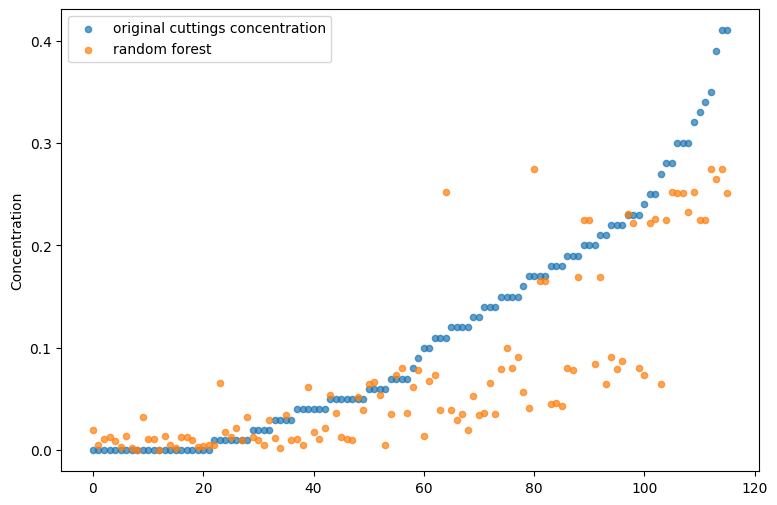

In [43]:
plt.figure(figsize=(9, 6))

plt.scatter(comparison_abs.index, comparison_abs['Original Concentration'], label = 'original cuttings concentration', alpha = .7, s = 20)
plt.scatter(comparison_abs.index, comparison_abs['RF_Optimized Concentration'], label = 'random forest', alpha = .7, s = 20)
plt.ylabel('Concentration')
plt.legend()

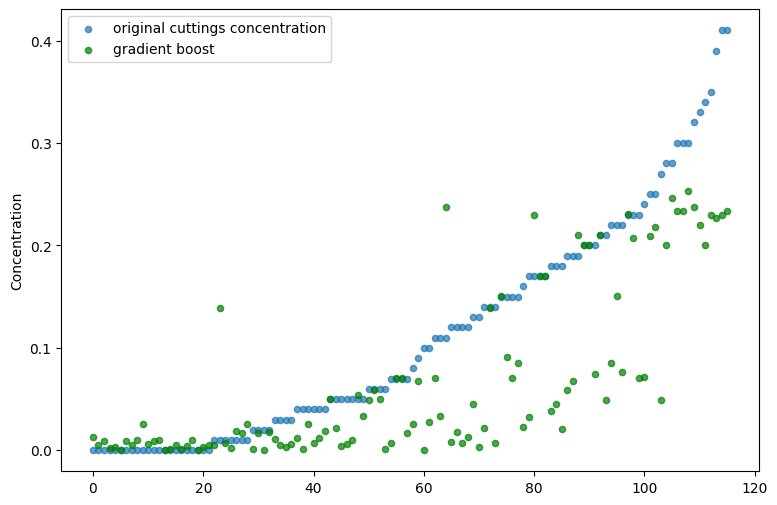

In [42]:
from turtle import color


plt.figure(figsize=(9, 6))

plt.scatter(comparison_abs.index, comparison_abs['Original Concentration'], label = 'original cuttings concentration', alpha = .7, s = 20)
plt.scatter(comparison_abs.index, comparison_abs['GB_Optimized Concentration'], label = 'gradient boost', alpha = .7, color= 'green', s = 20)
plt.ylabel('Concentration')
plt.legend()

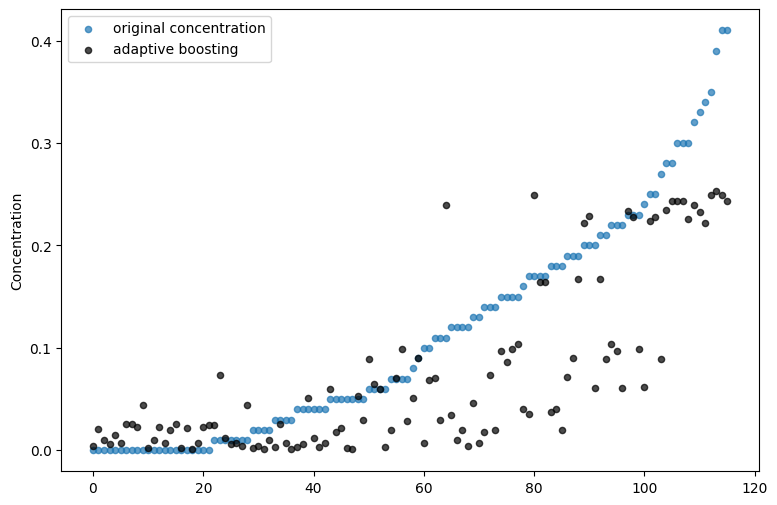

In [41]:
plt.figure(figsize=(9, 6))

plt.scatter(comparison_abs.index, comparison_abs['Original Concentration'], label = 'original cuttings concentration', alpha = .7, s = 20)
plt.scatter(comparison_abs.index, comparison_abs['ADA_Optimized Concentration'], label = 'adaptive boosting', alpha = .7, color = 'black', s = 20)
plt.ylabel('Concentration')
plt.legend()

### Stacked Model

In [ ]:
rf_train, rf_test = model_metric(rf_model, X_train, y_train, X_test, y_test, silent=False)
df_rf = np.append(rf_train, rf_test)

gb_train, gb_test = model_metric(gb_model, X_train, y_train, X_test, y_test, silent=False)
df_gb = np.append(gb_train, gb_test)

ada_train, ada_test = model_metric(ada_model, X_train, y_train, X_test, y_test, silent=False)
df_ada = np.append(ada_train, ada_test)

dataframe = pd.DataFrame({'RF': df_rf.squeeze(), 'GB': df_gb.squeeze(), 'ADA': df_ada.squeeze()})
stack_target = pd.Series(np.append(y_train, y_test))

x_train, x_test, Y_train, Y_test = train_test_split(dataframe, stack_target, random_state = 6, test_size = .25)

stack = Ridge(alpha =0.245)

model_metric(stack, x_train, Y_train, x_test, Y_test, silent = True)

In [54]:
stack_data = comparison.sort_values(by = 'Original Concentration').iloc[:, 1:].rename({'RF_Optimized Concentration':'df_rf', 'GB_Optimized Concentration':'df_gb', 'ADA_Optimized Concentration':'df_ada'}, axis = 1)

In [70]:
comparison_abs['Stacked_Optimized_Concentration'] = np.abs(np.round(stack.predict(stack_data), 3))

In [71]:
comparison_abs.to_csv('files/optimized_concentration.csv', index=False)

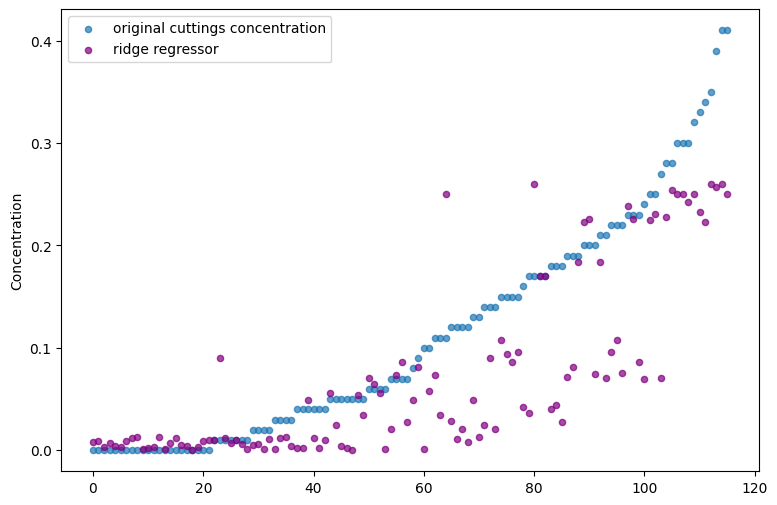

In [72]:
plt.figure(figsize=(9, 6))

plt.scatter(comparison_abs.index, comparison_abs['Original Concentration'], label = 'original cuttings concentration', alpha = .7, s = 20)
plt.scatter(comparison_abs.index, comparison_abs['Stacked_Optimized_Concentration'], label = 'ridge regressor', alpha = .7, color = 'purple', s = 20)
plt.ylabel('Concentration')
plt.legend()

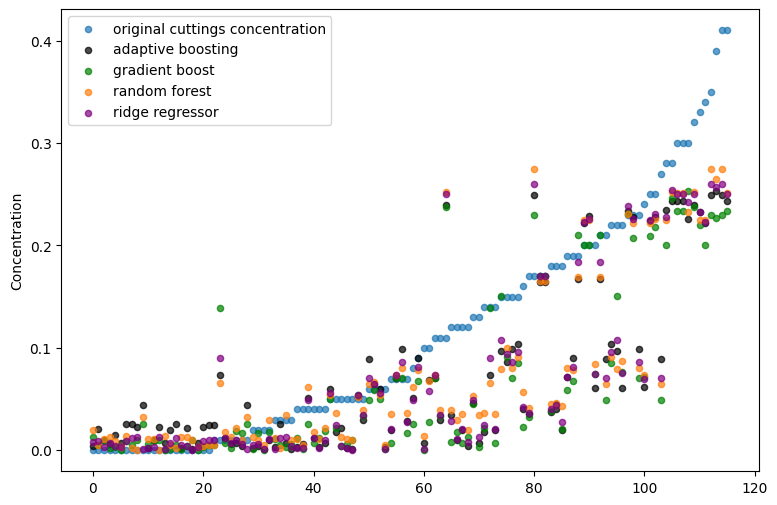

In [73]:
plt.figure(figsize=(9, 6))

plt.scatter(comparison_abs.index, comparison_abs['Original Concentration'], label = 'original cuttings concentration', alpha = .7, s = 20)
plt.scatter(comparison_abs.index, comparison_abs['ADA_Optimized Concentration'], label = 'adaptive boosting', alpha = .7, color = 'black', s = 20)
plt.scatter(comparison_abs.index, comparison_abs['GB_Optimized Concentration'], label = 'gradient boost', alpha = .7, color= 'green', s = 20)
plt.scatter(comparison_abs.index, comparison_abs['RF_Optimized Concentration'], label = 'random forest', alpha = .7, s = 20)
plt.scatter(comparison_abs.index, comparison_abs['Stacked_Optimized_Concentration'], label = 'ridge regressor', alpha = .7, color = 'purple', s = 20)
plt.ylabel('Concentration')
plt.legend();

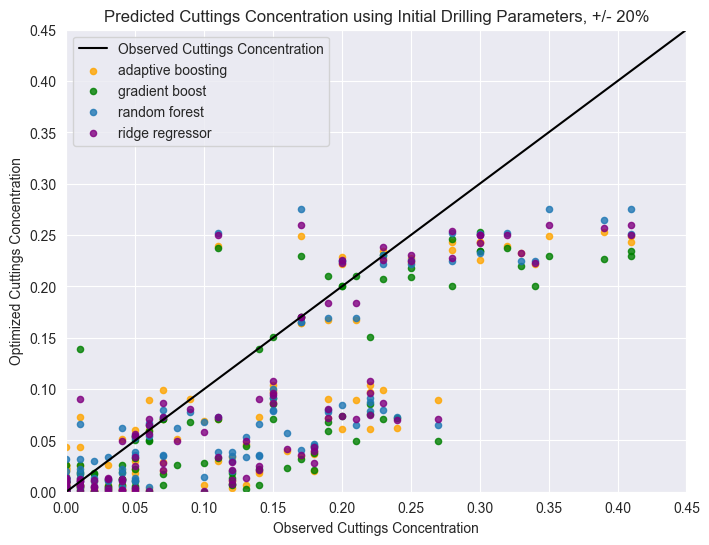

In [91]:
sns.set_style('darkgrid')
plt.figure(figsize=(8, 6))

plt.plot([0, 0.45], [0, 0.45], color = 'black', label = 'Observed Cuttings Concentration')
plt.scatter(comparison_abs['Original Concentration'], comparison_abs['ADA_Optimized Concentration'], label = 'adaptive boosting', alpha = .8, color = 'orange', s = 20)
plt.scatter(comparison_abs['Original Concentration'], comparison_abs['GB_Optimized Concentration'], label = 'gradient boost', alpha = .8, color= 'green', s = 20)
plt.scatter(comparison_abs['Original Concentration'], comparison_abs['RF_Optimized Concentration'], label = 'random forest', alpha = .8, s = 20)
plt.scatter(comparison_abs['Original Concentration'], comparison_abs['Stacked_Optimized_Concentration'], label = 'ridge regressor', alpha = .8, color = 'purple', s = 20)
plt.ylabel('Optimized Cuttings Concentration')
plt.xlabel('Observed Cuttings Concentration')
plt.ylim(0,0.45)
plt.xlim(0, 0.45)
plt.legend()
plt.title('Predicted Cuttings Concentration using Initial Drilling Parameters, +/- 20%')
plt.savefig(fname = 'files/optimizaton_performance.png', format = 'png');